Using device: cuda


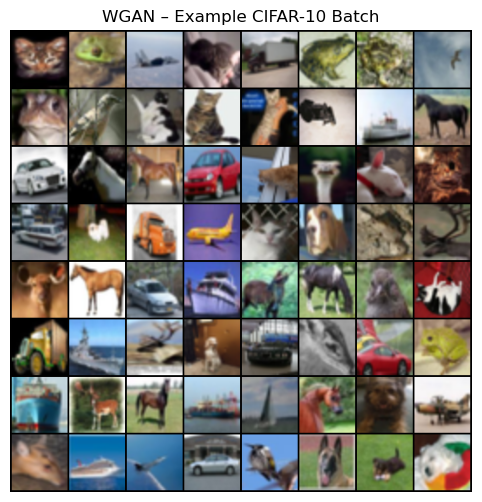

In [1]:
import os
from dataclasses import dataclass
from typing import List, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
from torchvision.models.inception import inception_v3, Inception_V3_Weights
from scipy import linalg
import matplotlib.pyplot as plt

%matplotlib inline

torch.backends.cudnn.benchmark = True


@dataclass
class WGANConfig:
    epochs: int = 50
    batch_size: int = 128
    z_dim: int = 100
    g_channels: int = 64
    c_channels: int = 64
    lr: float = 2e-4
    beta1: float = 0.5
    beta2: float = 0.999
    n_critic: int = 3
    lambda_gp: float = 10.0
    image_size: int = 64
    channels: int = 3
    fid_samples: int = 2048  # real/fake samples for FID


cfg = WGANConfig()


def set_seed(seed: int = 42) -> None:
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

RESULTS_DIR = "WGAN_results"
os.makedirs(os.path.join(RESULTS_DIR, "GeneratedImages"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "RealImages"), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, "Metrics"), exist_ok=True)

# CIFAR-10 data pipeline
transform = transforms.Compose([
    transforms.Resize((cfg.image_size, cfg.image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=transform,
)

train_loader = DataLoader(
    train_set,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True,
)

# Quick sanity check: show a batch of real images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 6))
plt.axis("off")
plt.title("WGAN – Example CIFAR-10 Batch")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0][:64], padding=2, normalize=True),
        (1, 2, 0),
    )
)
plt.show()


In [2]:
class WGANGenerator(nn.Module):
    """Generator network for WGAN-GP (64×64 RGB)."""
    def __init__(self, z_dim: int, base_ch: int, img_ch: int):
        super().__init__()
        self.net = nn.Sequential(
            self._block(z_dim, base_ch * 8, 4, 1, 0),
            self._block(base_ch * 8, base_ch * 4, 4, 2, 1),
            self._block(base_ch * 4, base_ch * 2, 4, 2, 1),
            self._block(base_ch * 2, base_ch, 4, 2, 1),
            nn.ConvTranspose2d(base_ch, img_ch, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    @staticmethod
    def _block(in_ch: int, out_ch: int, k: int, s: int, p: int) -> nn.Sequential:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, k, s, p, bias=False),
            nn.BatchNorm2d(out_ch, momentum=0.9),
            nn.ReLU(True),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.net(z)


class WGANCritic(nn.Module):
    """
    Critic (discriminator) for WGAN-GP.

    Note: no sigmoid at the end – outputs real-valued scores.
    """
    def __init__(self, img_ch: int, base_ch: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_ch, base_ch, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_ch, base_ch * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(base_ch * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_ch * 2, base_ch * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(base_ch * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_ch * 4, base_ch * 8, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(base_ch * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_ch * 8, 1, 4, 2, 0, bias=False),  # → (B,1,1,1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def init_wgan_weights(m: nn.Module) -> None:
    """Heuristic DCGAN-style weight init."""
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d, nn.InstanceNorm2d)):
        if hasattr(m, "weight") and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            nn.init.zeros_(m.bias.data)


G = WGANGenerator(cfg.z_dim, cfg.g_channels, cfg.channels).to(device)
C = WGANCritic(cfg.channels, cfg.c_channels).to(device)
G.apply(init_wgan_weights)
C.apply(init_wgan_weights)

print(G)
print(C)


WGANGenerator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (2): ReLU(inplac

In [3]:
class FIDEvaluator(nn.Module):
    """
    FID helper using Inception-v3.
    Works similarly for DCGAN and WGAN for comparison.
    """
    def __init__(self, device: torch.device):
        super().__init__()
        weights = Inception_V3_Weights.IMAGENET1K_V1
        inception = inception_v3(weights=weights, transform_input=False)
        inception.fc = nn.Identity()
        self.inception = inception.to(device).eval()
        for p in self.inception.parameters():
            p.requires_grad_(False)
        self.device = device

    @torch.no_grad()
    def _features(self, imgs: torch.Tensor) -> np.ndarray:
        # imgs expected in [-1, 1]
        imgs = (imgs + 1) / 2  # → [0,1]
        imgs = F.interpolate(imgs, size=(299, 299),
                             mode="bilinear", align_corners=False)
        out = self.inception(imgs.to(self.device))
        if isinstance(out, tuple):  # some versions return (logits, aux)
            out = out[0]
        return out.cpu().numpy()

    def _stats(self, feats: np.ndarray):
        mu = np.mean(feats, axis=0)
        sigma = np.cov(feats, rowvar=False)
        return mu, sigma

    def forward(self, real: torch.Tensor, fake: torch.Tensor) -> float:
        real_f = self._features(real)
        fake_f = self._features(fake)
        mu1, sigma1 = self._stats(real_f)
        mu2, sigma2 = self._stats(fake_f)

        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if not np.isfinite(covmean).all():
            eps = 1e-6
            covmean = linalg.sqrtm(
                (sigma1 + np.eye(sigma1.shape[0]) * eps).dot(
                    sigma2 + np.eye(sigma2.shape[0]) * eps
                )
            )
        if np.iscomplexobj(covmean):
            covmean = covmean.real

        fid = np.sum((mu1 - mu2) ** 2) + np.trace(
            sigma1 + sigma2 - 2 * covmean
        )
        return float(fid)


def gradient_penalty(critic: nn.Module,
                     real: torch.Tensor,
                     fake: torch.Tensor,
                     device: torch.device) -> torch.Tensor:
    """Compute WGAN-GP gradient penalty."""
    bsz, ch, h, w = real.shape
    eps = torch.rand(bsz, 1, 1, 1, device=device).expand(-1, ch, h, w)
    interpolated = eps * real + (1 - eps) * fake
    interpolated.requires_grad_(True)

    mixed_scores = critic(interpolated)

    grad = torch.autograd.grad(
        outputs=mixed_scores,
        inputs=interpolated,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    grad = grad.view(bsz, -1)
    grad_norm = grad.norm(2, dim=1)
    gp = ((grad_norm - 1) ** 2).mean()
    return gp


def critic_accuracy(real_scores: torch.Tensor, fake_scores: torch.Tensor) -> float:
    """
    Heuristic accuracy: treat score > 0 as 'real' and < 0 as 'fake'.
    Measures how often critic assigns correct sign.
    """
    real_pred = (real_scores.view(-1) > 0).float()
    fake_pred = (fake_scores.view(-1) < 0).float()
    correct = real_pred.sum() + fake_pred.sum()
    total = real_scores.numel() + fake_scores.numel()
    return (correct / total).item() * 100.0


fid_eval = FIDEvaluator(device)

opt_G = optim.Adam(G.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))
opt_C = optim.Adam(C.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))

fixed_noise = torch.randn(64, cfg.z_dim, 1, 1, device=device)


In [4]:
def save_grid(tensor: torch.Tensor, path: str, title: str = "") -> None:
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    if title:
        plt.title(title)
    grid = vutils.make_grid(tensor, padding=2, normalize=True)
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.savefig(path, bbox_inches="tight")
    plt.close()


def plot_wgan_training(history: Dict[str, List[float]]) -> None:
    epochs = list(range(1, len(history["gen_losses"]) + 1))

    plt.figure(figsize=(18, 5))

    # Losses
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["gen_losses"], label="Generator Loss")
    plt.plot(epochs, history["critic_losses"], label="Critic Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("WGAN Training Losses")
    plt.legend()

    # Critic accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["critic_acc"], label="Critic Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("WGAN Critic Accuracy")
    plt.legend()

    # FID
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["fid_scores"], label="FID Score")
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("WGAN FID Progress")
    plt.legend()

    plt.tight_layout()
    out_path = os.path.join(RESULTS_DIR, "Metrics", "wgan_training_curves.png")
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    print(f"Saved WGAN training curves to {out_path}")


In [14]:
epoch_ids: List[int] = []
gen_losses: List[float] = []
critic_losses: List[float] = []
critic_acc_list: List[float] = []
fid_scores: List[float] = []

best_fid = float("inf")
best_epoch = -1
best_G_state = None
best_C_state = None

print("Starting WGAN-GP training...")
for epoch in range(cfg.epochs):
    G.train()
    C.train()

    running_g_loss = 0.0
    running_c_loss = 0.0
    running_acc = 0.0

    real_samples_for_fid = []
    fake_samples_for_fid = []

    num_batches = len(train_loader)

    for batch_idx, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        bsz = real_imgs.size(0)

        # ----------- Train Critic (n_critic steps) -----------
        for _ in range(cfg.n_critic):
            noise = torch.randn(bsz, cfg.z_dim, 1, 1, device=device)
            fake_imgs = G(noise)

            real_scores = C(real_imgs)
            fake_scores = C(fake_imgs.detach())

            gp = gradient_penalty(C, real_imgs, fake_imgs.detach(), device)
            loss_C = -(real_scores.mean() - fake_scores.mean()) + cfg.lambda_gp * gp

            opt_C.zero_grad(set_to_none=True)
            loss_C.backward()
            opt_C.step()

        # critic "accuracy" (heuristic: real>0, fake<0)
        batch_acc = critic_accuracy(real_scores.detach(), fake_scores.detach())
        running_acc += batch_acc

        # -------------------- Train Generator --------------------
        noise = torch.randn(bsz, cfg.z_dim, 1, 1, device=device)
        fake_imgs = G(noise)
        fake_scores_for_G = C(fake_imgs)
        loss_G = -fake_scores_for_G.mean()

        opt_G.zero_grad(set_to_none=True)
        loss_G.backward()
        opt_G.step()

        running_g_loss += loss_G.item()
        running_c_loss += loss_C.item()

        # keep a few batches for FID
        if batch_idx < 5:
            real_samples_for_fid.append(real_imgs.detach())
            fake_samples_for_fid.append(fake_imgs.detach())

    avg_g = running_g_loss / num_batches
    avg_c = running_c_loss / num_batches
    avg_acc = running_acc / num_batches

    # -------------------- FID for this epoch --------------------
    with torch.no_grad():
        real_pool = torch.cat(real_samples_for_fid, dim=0)[: cfg.fid_samples]
        fake_pool = torch.cat(fake_samples_for_fid, dim=0)[: cfg.fid_samples]
        fid_value = fid_eval(real_pool, fake_pool)

    epoch_ids.append(epoch + 1)
    gen_losses.append(avg_g)
    critic_losses.append(avg_c)
    critic_acc_list.append(avg_acc)
    fid_scores.append(fid_value)

    # track best FID
    if fid_value < best_fid:
        best_fid = fid_value
        best_epoch = epoch + 1
        best_G_state = G.state_dict()
        best_C_state = C.state_dict()

    print(
        f"Epoch [{epoch+1}/{cfg.epochs}]  "
        f"C_loss: {avg_c:.4f}  G_loss: {avg_g:.4f}  "
        f"Acc: {avg_acc:5.2f}%  FID: {fid_value:.2f}"
    )

    # -------- Save generated samples every few epochs --------
    if (epoch + 1) % 5 == 0 or (epoch + 1) == cfg.epochs:
        G.eval()
        with torch.no_grad():
            fake_fixed = G(fixed_noise).cpu()   # 64 images → 8×8 grid
        save_grid(
            fake_fixed,
            os.path.join(
                RESULTS_DIR,
                "GeneratedImages",
                f"wgan_epoch_{epoch+1:03d}.png",
            ),
            title=f"WGAN Generated Images at Epoch {epoch+1}",
        )

print("Training loop finished")
print(f"Best FID {best_fid:.2f} observed at epoch {best_epoch}")

# -------- Load best weights and save one more 'best' grid --------
if best_G_state is not None:
    G.load_state_dict(best_G_state)
if best_C_state is not None:
    C.load_state_dict(best_C_state)

G_trained = G
C_trained = C

with torch.no_grad():
    best_fake = G_trained(fixed_noise).cpu()

save_grid(
    best_fake,
    os.path.join(
        RESULTS_DIR,
        "GeneratedImages",
        f"wgan_best_epoch_{best_epoch:03d}.png",
    ),
    title=f"WGAN Best Epoch {best_epoch} (FID={best_fid:.2f})",
)

# history dict for plotting later
wgan_history: Dict[str, List[float]] = {
    "epoch_ids": epoch_ids,
    "gen_losses": gen_losses,
    "critic_losses": critic_losses,
    "critic_acc": critic_acc_list,
    "fid_scores": fid_scores,
    "best_epoch": [best_epoch],
    "best_fid": [best_fid],
}


Starting WGAN-GP training...
Epoch [1/50]  C_loss: -3.7977  G_loss: 54.9254  Acc: 50.00%  FID: 76.91
Epoch [2/50]  C_loss: -3.8068  G_loss: 55.5722  Acc: 50.01%  FID: 74.35
Epoch [3/50]  C_loss: -3.8077  G_loss: 55.7165  Acc: 50.00%  FID: 74.83
Epoch [4/50]  C_loss: -3.8201  G_loss: 56.0967  Acc: 50.00%  FID: 76.21
Epoch [5/50]  C_loss: -3.8666  G_loss: 56.8023  Acc: 50.00%  FID: 77.82
Epoch [6/50]  C_loss: -3.9157  G_loss: 57.1318  Acc: 50.00%  FID: 78.25
Epoch [7/50]  C_loss: -3.8991  G_loss: 57.3318  Acc: 50.00%  FID: 75.11
Epoch [8/50]  C_loss: -3.9439  G_loss: 57.8346  Acc: 50.00%  FID: 74.16
Epoch [9/50]  C_loss: -3.9550  G_loss: 57.9584  Acc: 50.00%  FID: 73.81
Epoch [10/50]  C_loss: -3.9377  G_loss: 58.2547  Acc: 50.00%  FID: 81.16
Epoch [11/50]  C_loss: -3.9686  G_loss: 58.8658  Acc: 50.00%  FID: 78.53
Epoch [12/50]  C_loss: -3.9860  G_loss: 59.8685  Acc: 50.00%  FID: 76.91
Epoch [13/50]  C_loss: -4.0006  G_loss: 59.6518  Acc: 50.00%  FID: 76.88
Epoch [14/50]  C_loss: -4.0382 

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Same transforms as WGAN training
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Reload CIFAR-10 (will not redownload)
train_set = datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=False,
    transform=transform,
)

train_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True,
)

print("train_loader is ready!")


train_loader is ready!


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils as vutils

real_dir = os.path.join("WGAN_results", "RealImages")
os.makedirs(real_dir, exist_ok=True)

real_batch = next(iter(train_loader))
real_imgs = real_batch[0][:64]

out_path = os.path.join(real_dir, "wgan_real_grid.png")

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Real CIFAR-10 Images (WGAN)")
grid = vutils.make_grid(real_imgs, padding=2, normalize=True)
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.savefig(out_path, bbox_inches="tight")
plt.close()

print("Saved real grid to:", out_path)


Saved real grid to: WGAN_results/RealImages/wgan_real_grid.png


In [7]:
from PIL import Image
import os

RESULTS_DIR = "WGAN_results"

real_path = os.path.join(RESULTS_DIR, "RealImages", "wgan_real_grid.png")
fake_path = os.path.join(RESULTS_DIR, "GeneratedImages", "wgan_epoch_045.png")  # change if needed

real_img = Image.open(real_path).convert("RGB")
fake_img = Image.open(fake_path).convert("RGB")

# Resize real & fake to same height
h = min(real_img.height, fake_img.height)
real_img = real_img.resize((int(real_img.width * h / real_img.height), h))
fake_img = fake_img.resize((int(fake_img.width * h / fake_img.height), h))

# Combine into one canvas
combined = Image.new("RGB", (real_img.width + fake_img.width, h))
combined.paste(real_img, (0, 0))
combined.paste(fake_img, (real_img.width, 0))

combined_path = os.path.join(RESULTS_DIR, "Metrics", "wgan_combined_final.png")
os.makedirs(os.path.dirname(combined_path), exist_ok=True)
combined.save(combined_path)

print("Saved combined image:", combined_path)


Saved combined image: WGAN_results/Metrics/wgan_combined_final.png


In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
from torchvision import utils as vutils

# ---------- pick the best epoch from FID ----------
best_idx = int(np.argmin(fid_scores))      # index of lowest FID
best_epoch = epoch_ids[best_idx]

final_gen_loss = gen_losses[best_idx]
final_critic_loss = critic_losses[best_idx]
final_critic_acc = critic_acc_list[best_idx]
final_fid = fid_scores[best_idx]

print("Final Metrics (WGAN – best FID epoch):")
print(f"Best Epoch: {best_epoch}")
print(f"Generator Loss: {final_gen_loss:.4f}")
print(f"Critic Loss: {final_critic_loss:.4f}")
print(f"Critic Accuracy: {final_critic_acc:.2f}%")
print(f"Quality Score (FID): {final_fid:.4f}")

# ---------- 1) Training curves ----------
wgan_history_for_plot = {
    "gen_losses": gen_losses,
    "critic_losses": critic_losses,
    "critic_acc": critic_acc_list,
    "fid_scores": fid_scores,
}
plot_wgan_training(wgan_history_for_plot)

# ---------- 2) Real vs Generated grids ----------
RESULTS_DIR = "WGAN_results"

# use trained generator (G_trained if you have it, else G)
G_use = G_trained if "G_trained" in globals() else G
G_use.eval()

# real grid
real_imgs = real_batch[0][:64].cpu()
real_grid = vutils.make_grid(real_imgs, padding=2, normalize=True)

# fake grid
with torch.no_grad():
    fake_imgs = G_use(fixed_noise).cpu()
fake_grid = vutils.make_grid(fake_imgs, padding=2, normalize=True)

# save individual grids
save_grid(
    real_imgs,
    os.path.join(RESULTS_DIR, "RealImages", "wgan_real_grid.png"),
    title="Real Images"
)
save_grid(
    fake_imgs,
    os.path.join(RESULTS_DIR, "GeneratedImages", "wgan_fake_grid_final.png"),
    title="Generated Images"
)

# ---------- 3) Side-by-side combined figure ----------
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title("Real Images")
plt.axis("off")
plt.imshow(np.transpose(real_grid.numpy(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.title("WGAN Generated Images")
plt.axis("off")
plt.imshow(np.transpose(fake_grid.numpy(), (1, 2, 0)))

combined_path = os.path.join(RESULTS_DIR, "wgan_combined_final.png")
plt.savefig(combined_path, bbox_inches="tight")
plt.show()

print("\nSaved WGAN results in WGAN_results directory")


NameError: name 'fid_scores' is not defined